# Variational autoencoder

#### References 

- Chollet2018 - Deep Learning with Python
- [Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114.pdf)
- [알기쉬운 Variational autoencoder](https://www.slideshare.net/ssuser06e0c5/variational-autoencoder-76552518)
- [jaan 개인 블로그](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/)

#### 생성 모델로서의 Aariational autoencoder 

아래의 그림은 Variational autoencoder(이하 VAE)의 구조이다. VAE는 Generative Model 중 하나로, 확률분포($P(x)$)를 학습함으로써, 데이터를 생성하는 것이 목적이다.

Encoder 네트워크는 학습용 데이터(이하 $x$)를 입력으로 받고 잠재 변수(이하 $z$)의 확률분포에 대한 파라미터를 출력한다(Gaussian 정규 분포의 경우, $\mu, \sigma^2$). 그리고 Decoder는 잠재변수에 대한 확률 분포 $p(z)$에서 샘플링한 벡터를 입력받아, 이를 이용해 원본 이미지를 복원한다. 

VAE는 최적화를 통해 아래의 두가지 문제를 푼다.
1. 하나는 주어진 데이터를 잘 설명하는 잠재 변수의 분포를 찾는 것이고, (Encoder의 역할)
2. 두번째는 잠재변수로 부터 원본 이미지와 같은 이미지를 잘 복원하는 것이다. (Decoder의 역할)

<img src="https://datascienceschool.net/upfiles/f38b90fa89cb46eba22178edbae07a26.png" style="width: 100%;">

그림  : Variational autoencoder의 구조 

### Encoder
Encoder의 역할은 데이터가 주어졌을 때 Decoder가 원래의 데이터로 잘 복원할 수 있는 $z$를 샘플링 할 수 있는 이상적인 확률분포 $p(z|x)$를 찾는 것이다. 하지만 어떤 것이 이상적인 확률분포 $p(z|x)$ 인지는 아무도 모른다. VAE 방법론에서는 이 문제를 해결하기 위해 **Variational inference**를 사용한다. 

#### Variational inference

**Variational inference**란, 우리가 이상적인 확률분포를 모르지만, 이를 추정하기 위해서 다루기 쉬운 분포(approximation class, 대표적으로 Gaussian distribution)를 가정하고 이 확률분포의 모수를 바꿔가며, 이상적인 확률분포에 근사하게 만들어 그 확률분포를 대신 사용하는 것이다. 이 다루기 쉬운 분포를 $q_{\phi}$ 라고 한다면, Encoder는 $\phi$라는 파라미터들을 바꾸어가며, $q_{\phi}(z|x)$ 확률 분포를 이상적인 확률 분포 $p(z|x)$에 근사시키는 역할을 수행한다. 보통 $q_{\phi}(\cdot)$은 Gaussian 정규 분포라고 가정한다. 이유는 뒤에서 설명 할 것이다. 그리고 이때, $z$의 marginal distribution은 평균이 0이고 분산이 1인 표준 정규분포로 가정한다. 아래의 코드가 encoder부분을 구현 한 것이다. 

<img src="https://datascienceschool.net/upfiles/da522e75af6544c1a4ae09be69ed1a48.png" style="width: 100%;">

그림  : Variational Inference 

In [1]:
from keras import metrics
from keras import layers
from keras.models import Model
from keras import backend as K
import numpy as np
%matplotlib inline

Using TensorFlow backend.


In [2]:
# encoder
img_shape = (28, 28, 1)
latent_dim = 2

input_layer = layers.Input(shape=img_shape)

e = layers.Conv2D(32, 3, padding='same', activation='relu')(input_layer)
e = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(e)
e = layers.Conv2D(64, 3, padding='same', activation='relu')(e)
e = layers.Conv2D(64, 3, padding='same', activation='relu')(e)

shape_before_flattening = K.int_shape(e)
flat = layers.Flatten()(e)
x = layers.Dense(32, activation='relu')(flat)

# 가정한 확률분포의 모수
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

### The reparameterization trick

Encoder가 출력하는 것은 $q_{\phi}(z|x)$ 확률 분포의 모수이다. 우리는 $q_{\phi}(z|x)$를 정규 분포라고 가정했기 때문에, 이 경우에는 평균과 분산이다. 다음 단계는 이 확률분포로 부터 샘플링을 하는 것이다. 이 때, 그냥 샘플링을 한다면, Back propagation이 불가능하다. Back propagation은 편미분을 구함으로써 Gradient를 구하는 것인데, $z$를 확률분포에서 그냥 샘플링 한다면 체인룰이 중간에 끊기게 된다. 여기서는 이를 극복하기 위해서 Reparameterization trick을 사용했다. 

Reparameterization trick이란, 가우시안 정규 분포의 샘플을 추출하고 싶을 때, 아래의 식과 같이 샘플링을 하는 것을 말한다. 이렇게 샘플을 추출 하더라도 원래의 확률적 특성을 보존 한다. 그리고 이렇게 샘플링 하면 $z$는 확률분포의 모수인 분산과 평균이 더해진 형태이므로 Back propagation 또한 가능하다.

$$z^{i, l} \tilde{} \ N(\mu_i, \sigma^2_{i}) \rightarrow z^{i, l} = \mu_i + \sigma^2_i \odot \epsilon \\ \epsilon \tilde{} \ N(0, 1)$$

In [3]:
def sampling(args):

    # Reparameterization trick for back-propagation
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1)
    return z_mean + K.exp(z_log_var) * epsilon


z = layers.Lambda(sampling)([z_mean, z_log_var])

### Decoder 

Decoder는 추출한 샘플을 입력으로 받아, 다시 원본으로 재구축하는 역할을 수행한다. 추후에 설명을 간편하기 위해서 이를 $\theta$ 라는 파라미터들을 가지는 $g_{\theta}(\cdot)$ 이라고 하겠다. 

In [4]:
# Decoder
decoder_input = layers.Input(K.int_shape(z)[1:])

x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)
z_decoded = decoder(z)

### Evidence LowerBOund (ELBO)

여기서는 수식에 대한 설명이 필요하니 잘 따라와 주길 바란다. 

우리가 궁극적으로 알고 싶은 것은 $p(x)$ 즉 실제 데이터의 분포를 알고 싶은 것이다. 앞서 나온 $p(z|x), \ q_\phi(z|x), p(z)$ 는 $p(x)$를 추정하기 위해 사용한 도구들이다. 이를 이용해 두가지 방법으로 식을 전개 해 볼 것이다.

#### Jensen's Inequality 
$\log(p(x))$는 확률의 전체확률 법칙에 의해 아래와 같다.

$$
\log(p(x)) = \log  \left ( \int p(x, z)dz \right ) = \log  \left ( \int p(x|z)p(z)dz \right ) 
$$
그리고 다음과 같이 $q_\phi(z|x)$를 넣어서 수식을 만들 수 있다.
$$
\log(p(x)) = \log \left ( \int p(x|z)\dfrac{p(z)}{q_\phi(z|x)}q_\phi(z|x)dz \right )\\
$$
이 때, [*Jenson's Inequality*](https://en.wikipedia.org/wiki/Jensen%27s_inequality) 에 의해 아래의 부등식이 성립한다.
$$
\log(p(x)) \geq \int \log \left ( p(x|z)\dfrac{p(z)}{q_\phi(z|x)} \right ) q_\phi(z|x)dz
$$
이 부등식을 다시 정리하면 아래와 같이 나타낼 수 있다. 
$$
\log(p(x)) \geq  \int \log(p(x|z))q_\phi(z|x)dz \ - \int \log \left ( \dfrac{q_\phi(z|x)}{p(z)} \right ) q_\phi(z|x)dz
$$
이 우변의 식을 Evidence LowerBOund 줄여서 $ELBO$라고 부른다. 이 $ELBO(\phi)$ 값을 최대화하는 $\phi$를 찾으면 위 식의 우변과 좌변은 같게 된다. 

이 식을 자세히 보면,
$$ 
\begin{eqnarray}
\int \log(p(x|z))q_\phi(z|x)dz \ &=& \mathbb{E}_{q_\phi(z|x)}[\log(p(x|z))]\\
\int \log \left ( \dfrac{q_\phi(z|x)}{p(z)} \right ) q_\phi(z|x)dz &=& KL(q_\phi(z|x)\|p(z) 
\end{eqnarray}
$$

따라서, $ELBO(\phi)$는 아래와 같이 정의 할 수 있다. 

$$
ELBO(\phi) = \mathbb{E}_{q_\phi(z|x)}[\log(p(x|z))] - KL(q_\phi(z|x)\|p(z) 
$$

#### Kullback–Leibler divergence

다시 $\log(p(x))$ 부터 식을 전개 한다. $\int q_\phi(z|x)dz = 1$ 이기 때문에 아래의 식이 성립한다. 
$$
\log(p(x)) = \int \log(p(x))q_\phi(z|x)dz 
$$
베이즈 룰을 이용해, $\log(p(x))$를 아래와 같이 표현 할 수 있다. 
$$
\begin{eqnarray}
\log(p(x)) &=& \int \log \left ( \dfrac{p(x, z)}{p(z|x)} \right )q_\phi(z|x)dz \\
&=& \int \log \left ( \dfrac{p(x,z)}{q_\phi(z|x)} \cdot \dfrac{q_\phi(z|x)}{p(z|x)} \right ) q_\phi(z|x) dz \\
&=& \int \log \left ( \dfrac{p(x, z)}{q_\phi(z|x)} \right ) q_\phi(z|x)dz + \int \log \left ( \dfrac{q_\phi(z|x)}{p(z|x)} \right ) q_\phi(z|x)dz 
\end{eqnarray}
$$
이 때, 
$\int \log \left ( \dfrac{p(x, z)}{q_\phi(z|x)} \right ) q_\phi(z|x)dz $ 는 $ELBO(\phi)$ 식과 똑같다. 

그리고 $\int \log \left ( \dfrac{q_\phi(z|x)}{p(z|x)} \right ) q_\phi(z|x)dz$ 는 $q_\phi(z|x)$ 와 $p(z|x)$ 간의 Kullback–Leibler divergence 값이다. (위의 $KL$ 식과는 다르므로 주의한다.)

$\log(p(x))$는 bound되어 있는 값이고, 이는 $ELBO(\phi)$와 $KL(q_\phi(z|x)\|p(z|x))$의 합이다. 따라서 아래의 그림처럼 $ELBO(\phi)$를 최대화하는 것이 곧, $KL(q_\phi(z|x)\|p(z|x))$를 최소화 하는 것이다. 

결론적으로, 이상적인 확률 분포 $p(x|z)$를 찾는다는 것은 $ELBO(\phi)$를 최대화하는 것과 같다. 

<img src="https://datascienceschool.net/upfiles/2b17600871204ad69d074389bab587c4.png" style="width: 50%;">

그림  : $ELBO$ 와 $KL$의 관계

다시 $ELBO(\phi)$를 써보면, 
$$
ELBO(\phi) = \mathbb{E}_{q_\phi(z|x)}[\log(p(x|z))] - KL(q_\phi(z|x)\|p(z) 
$$

이 때, $\log(p(x|z)$는 $z$를 입력으로 받아 $x$를 출력하는 함수로 Decoder의 목적과 동일하다. 이를 $\log(p_\theta(x|z))$로 바꾸어 표현하면, $\theta$를 조정하여 이를 최대화 하는 것이 또한, $ELBO$를 최대화하는 것이다. 

따라서, 최종 VAE의 Loss 함수는 아래와 같다. 

$$
\mathcal{L}_{(\theta, \phi ; x^i)} = - \ \mathbb{E}_{q_\phi(z|x^i)}[\log(p_\theta(x^i|z))] + KL(q_\phi(z|x^i)\|p(z)
$$

이 Loss 함수를 실제로 계산해보도록하자. 

1. $KL$ 
$$KL(q_\phi(z|x^i)\|p(z)$$

우리는 위에서 $q_\phi(z|x^i)$와 $p(z)$를 정규분포로 가정했다. 두 정규분포 간의 $KL$ 값은 아래와 같이 정의되어 있다. [증명](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Multivariate_normal_distributions)
$$
\begin{eqnarray}
KL(q_\phi(z|x^i)\|p(z) 
&=& \dfrac{1}{2} \left \{ tr(\sigma_i^2) + \mu_i^T\mu_i - J + \ln\dfrac{1}{\displaystyle\prod^J_{j=1}\sigma^2_{j,j}} \right \} \\
&=& \dfrac{1}{2} \left \{ \displaystyle\sum_{j=1}^J \sigma_{i,j}^2 + \displaystyle\sum_{j=1}^J \mu_{i,j}^2 - J - \displaystyle\sum_{j=1}^J\ln(\sigma_{i,j}^2) \right \} \\
&=& \dfrac{1}{2}\displaystyle\sum_{j=1}^j(\mu^2_{i,j} + \sigma^2_{i,j} - \ln(\sigma^2_{i,j}) - 1)
\end{eqnarray}
$$

위에서 Variational Inference에서 정규분포를 가정한 이유는 $KL$을 계산하는데 있어서, 정규 분포 이외의 분포간의 $KL$은 모수 만을 사용하여 계산하기 까다롭기 때문이다.

2. Expectation 
$$
\ \mathbb{E}_{q_\phi(z|x^i)}[\log(p_\theta(x^i|z))] \\ 
= \int log(p_\theta(x_i|z))q_\phi(z|x_i)dz 
$$
원래는 적분을 해야하지만, 딥러닝에서는 Mini-batch로 학습하기 때문에, $q_\phi$로 부터 L개의 데이터를 샘플링하여, Monte-carlo 방식으로 아래와 같이 구한다. 주로 편의상 L=1로 하여 계산한다.
$$
\mathbb{E}_{q_\phi(z|x^i)}[\log(p_\theta(x^i|z))] \approx \dfrac{1}{L} \displaystyle\sum_{z^{i,l}}\log(p_\theta(x^i|z^{i,l}))
$$

이 때, $p(x)$ Bernoulli 분포로 가정하면(이미지에서는 주로 Bernoulli 분포로 가정한다.), $\log(p_\theta(x^i|z^{i,l}))$ 값은 Cross Entropy 식이 된다. 아래 식에서 $p_{i,j}$ 네트워크의 출력값을 의미한다. 

$$
\begin{eqnarray}
\log(p_\theta(x^i|z^{i})) &=& \log \displaystyle\prod^D_{j=1}p_\theta(x_{i,j}|z^i) \\
&=&
\displaystyle\sum_{j=1}^D \log p_\theta(x_{i,j}|z^i)\\
&=&
\displaystyle\sum_{j=1}^D \log p_{i,j}^{x_{i,j}}(1-p_{i,j})^{x_{i,j}} \\
&=& 
\displaystyle\sum_{j=1}^D x_{i,j}\log p_{i,j} + (1 - x_{i,j})\log(1 - p_{i,j})
\end{eqnarray}
$$

In [5]:
class CustomVariationalLayer(layers.Layer):

    def vae_loss(self, x, z_decoded):

        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # 여기에서 - 가 곱해져 있다.
        cross_entropy_loss = metrics.binary_crossentropy(x, z_decoded)

#         kl_loss = 0.5 * K.mean(K.square(z_mean) + K.exp(z_log_var) - z_log_var - 1, axis=-1)
        kl_loss = -5e-4 * K.mean(1 + z_log_var -
                                 K.square(z_mean) - K.exp(z_log_var), axis=-1)

        return K.mean(cross_entropy_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x


y = CustomVariationalLayer()([input_layer, z_decoded])

In [6]:
vae = Model(input_layer, y)
vae.compile(optimizer='adam', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [7]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape, x_test.shape)

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

(60000, 28, 28) (10000, 28, 28)


In [8]:
%%time
vae.fit(x=x_train, y=None, shuffle=True, epochs=30,
        batch_size=100, validation_data=(x_test, None), verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 8s 129us/step - loss: 0.2586 - val_loss: 0.2104
Epoch 2/30
60000/60000 [==============================] - 5s 79us/step - loss: 0.2051 - val_loss: 0.2015
Epoch 3/30
60000/60000 [==============================] - 5s 78us/step - loss: 0.1984 - val_loss: 0.1966
Epoch 4/30
60000/60000 [==============================] - 5s 78us/step - loss: 0.1944 - val_loss: 0.1954
Epoch 5/30
60000/60000 [==============================] - 5s 79us/step - loss: 0.1918 - val_loss: 0.1910
Epoch 6/30
60000/60000 [==============================] - 5s 79us/step - loss: 0.1897 - val_loss: 0.1890
Epoch 7/30
60000/60000 [==============================] - 5s 79us/step - loss: 0.1879 - val_loss: 0.1890
Epoch 8/30
60000/60000 [==============================] - 5s 79us/step - loss: 0.1865 - val_loss: 0.1874
Epoch 9/30
60000/60000 [==============================] - 5s 79us/step - loss: 0.1852 - val_loss: 0.1860
Epoc

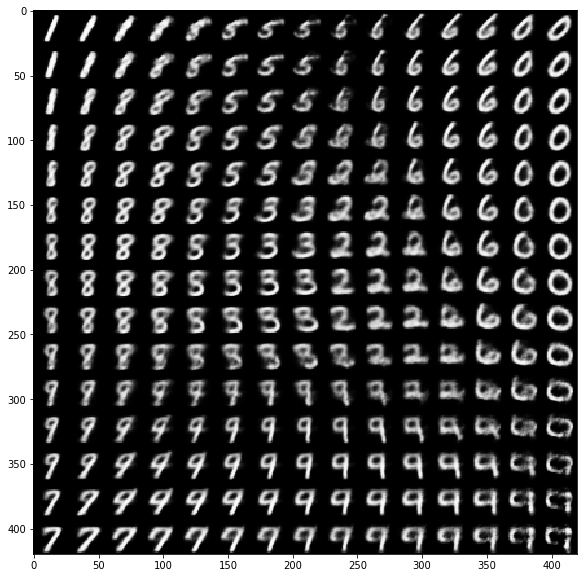

In [9]:
import matplotlib.pyplot as plt
from scipy.stats import norm

batch_size = 150
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)

        digit = x_decoded[0].reshape(digit_size, digit_size)

        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap="Greys_r")
plt.show()